name: Ricardo Leão Cardoso, Alexandrine Dif, Annabelle Ducret

# Heart Rate Estimation

The goal of this exercise is to estimate the heart rate from PPG and acceleration signals using regression methods. We use data from the PPG-DaLiA dataset (https://archive.ics.uci.edu/ml/datasets/PPG-DaLiA). It includes PPG and acceleration signals as well as the reference heart rate computed from an ECG signal. These signals were collected during various activity but we focus on two of them: sitting and walking.

First, we import all the packages we will need, define some global variables, and seed the random number generators.

In [1]:
%matplotlib widget


import copy
import itertools
import operator
import pathlib
import warnings
import IPython.display
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


DATA_FILE = pathlib.Path('../data/ppg_dalia.pkl')
LOG_DIRECTORY = pathlib.Path('../logs/hr_estimation')

Then, we load the PPG and acceleration signals as well as the reference heart rate. The signals are already pre-processed with the following steps:

* Band-pass filtering between 0.4 and 4.0 Hz (24 - 240 bpm).
* Resampling to 25 Hz.

We also define the window length and shift length used to compute the reference heart rate.

In [2]:
FS = 25.0  # Sampling frequency of the PPG and acceleration signals in Hertz.
WINDOW_LENGTH = 8.0  # Window duration in seconds used to compute the reference heart rate.
SHIFT_LENGTH = 2.0  # Shift between successive windows in seconds.

WINDOW_SIZE = round(FS * WINDOW_LENGTH)
SHIFT_SIZE = round(FS * SHIFT_LENGTH)

records = joblib.load(DATA_FILE)
subjects = set(record['subject'] for record in records)

print(f'Window length: {WINDOW_LENGTH} s (n = {WINDOW_SIZE})')
print(f'Shift length: {SHIFT_LENGTH} s (n = {SHIFT_SIZE})')
print(f'Number of records: {len(records)}')
print(f'Number of subjects: {len(subjects)}')

Window length: 8.0 s (n = 200)
Shift length: 2.0 s (n = 50)
Number of records: 29
Number of subjects: 15


Here are two examples of PPG and acceleration signals. One recorded when the subject is sitting and one recorded when the subject is walking.

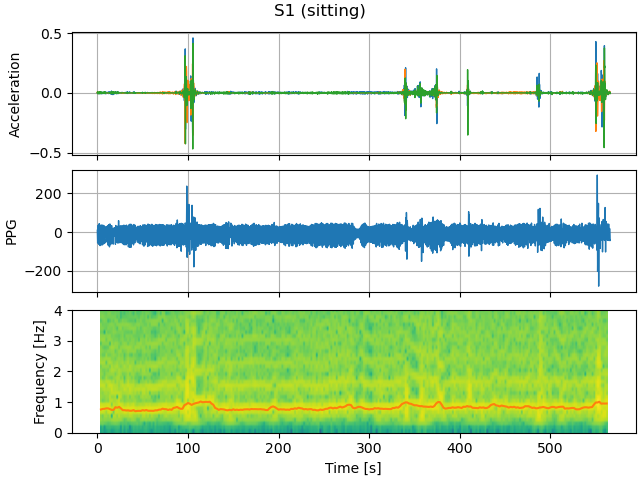

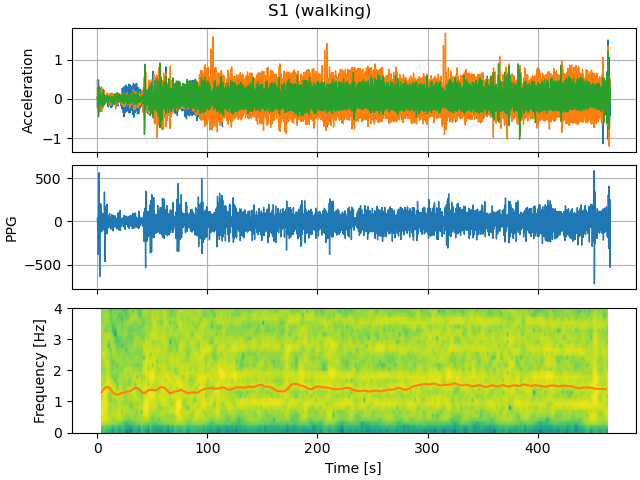

In [3]:
def plot_signals(record):
    signals = record['signals']
    hr = record['hr']

    fig, axes = plt.subplots(3, 1, sharex='all', constrained_layout=True)
    plt.suptitle(f'{record["subject"]} ({record["activity"]})')

    plt.sca(axes.flat[0])
    plt.plot(signals['time'].to_numpy(),
             signals[['acc_x', 'acc_y', 'acc_z']].to_numpy(),
             linewidth=1)
    plt.grid()
    plt.ylabel('Acceleration')

    plt.sca(axes.flat[1])
    plt.plot(signals['time'].to_numpy(), signals['ppg'].to_numpy(),
             linewidth=1)
    plt.grid()
    plt.ylabel('PPG')

    plt.sca(axes.flat[2])
    plt.specgram(signals['ppg'].to_numpy(), Fs=FS, NFFT=WINDOW_SIZE,
                 noverlap=WINDOW_SIZE - SHIFT_SIZE)
    plt.plot(hr['time'].to_numpy(), hr['hr'].to_numpy() / 60.0,
             color='tab:orange')
    plt.ylim(0.0, 4.0)
    plt.xlabel('Time [s]')
    plt.ylabel('Frequency [Hz]')
    
    
plot_signals(records[0])
plot_signals(records[1])

By zooming on the PPG signal, it is clear that walking cause a degradation in signal quality.

We will try to estimate the heart rate on sliding windows of the PPG and acceleration signals. To make things easier, we use the same window length and shift between windows as the reference heart rate.

So the next step is to extract sliding windows from all the records. We also extract the corresponding subject identifier for splitting the windows into subsets for training, validation, and testing.

In addition, we also prepare windows that include only the PPG signal (first channel).

In [4]:
def extract_windows(record):
    x = record['signals'][['ppg', 'acc_x', 'acc_y', 'acc_z']].to_numpy()
    n = x.shape[0]

    windows = []
    for i, start in enumerate(range(0, n - WINDOW_SIZE + 1, SHIFT_SIZE)):
        end = start + WINDOW_SIZE
        windows.append(x[start:end].T)
    windows = np.stack(windows)
    targets = record['hr']['hr'].to_numpy()

    return windows, targets


def extract_all_windows(records):
    windows = []
    targets = []
    subjects = []
    activities = []
    for record in records:
        x, y = extract_windows(record)
        windows.append(x)
        targets.append(y)
        subjects.extend(itertools.repeat(record['subject'], x.shape[0]))
        activities.extend(itertools.repeat(record['activity'], x.shape[0]))

    windows = np.concatenate(windows, axis=0)
    targets = np.concatenate(targets)[:, None]
    subjects = np.array(subjects)
    activities = np.array(activities)

    return windows, targets, subjects, activities


ppg_acc_windows, targets, subjects, activities = extract_all_windows(records)
ppg_windows = ppg_acc_windows[:, 0, :]

print(f'Shape of PPG and accleration windows: {ppg_acc_windows.shape}')
print(f'Shape of PPG windows: {ppg_windows.shape}')

Shape of PPG and accleration windows: (7420, 4, 200)
Shape of PPG windows: (7420, 200)


We have 7420 windows with 1 or 4 channels and that each window includes 200 samples (8 seconds at 25 Hz).

Next, we split the windows for training, validation, and testing by subjects. The test set includes 9 subjects, the validation set 3 subjects, and the test set 3 subjects.

In [5]:
def split_subjects(subjects):
    val_subjects = ('S10', 'S11', 'S12')
    test_subjects = ('S13', 'S14', 'S15')

    i_val = np.flatnonzero(np.isin(subjects, val_subjects))
    i_test = np.flatnonzero(np.isin(subjects, test_subjects))
    i_train = np.setdiff1d(np.arange(subjects.size), np.union1d(i_val, i_test))

    assert not (set(subjects[i_train]) & set(subjects[i_val]))
    assert not (set(subjects[i_train]) & set(subjects[i_test]))
    assert not (set(subjects[i_val]) & set(subjects[i_test]))
    assert (set(subjects[i_train]) | set(subjects[i_val]) | set(subjects[i_test])) == set(subjects)

    return i_train, i_val, i_test


i_train, i_val, i_test = split_subjects(subjects)

print(f'Subject used for training   : {pd.unique(subjects[i_train])}')
print(f'Subject used for validation : {pd.unique(subjects[i_val])}')
print(f'Subject used for testing    : {pd.unique(subjects[i_test])}')

Subject used for training   : ['S1' 'S2' 'S3' 'S4' 'S5' 'S6' 'S7' 'S8' 'S9']
Subject used for validation : ['S10' 'S11' 'S12']
Subject used for testing    : ['S13' 'S14' 'S15']


Now we extract features from the windows.

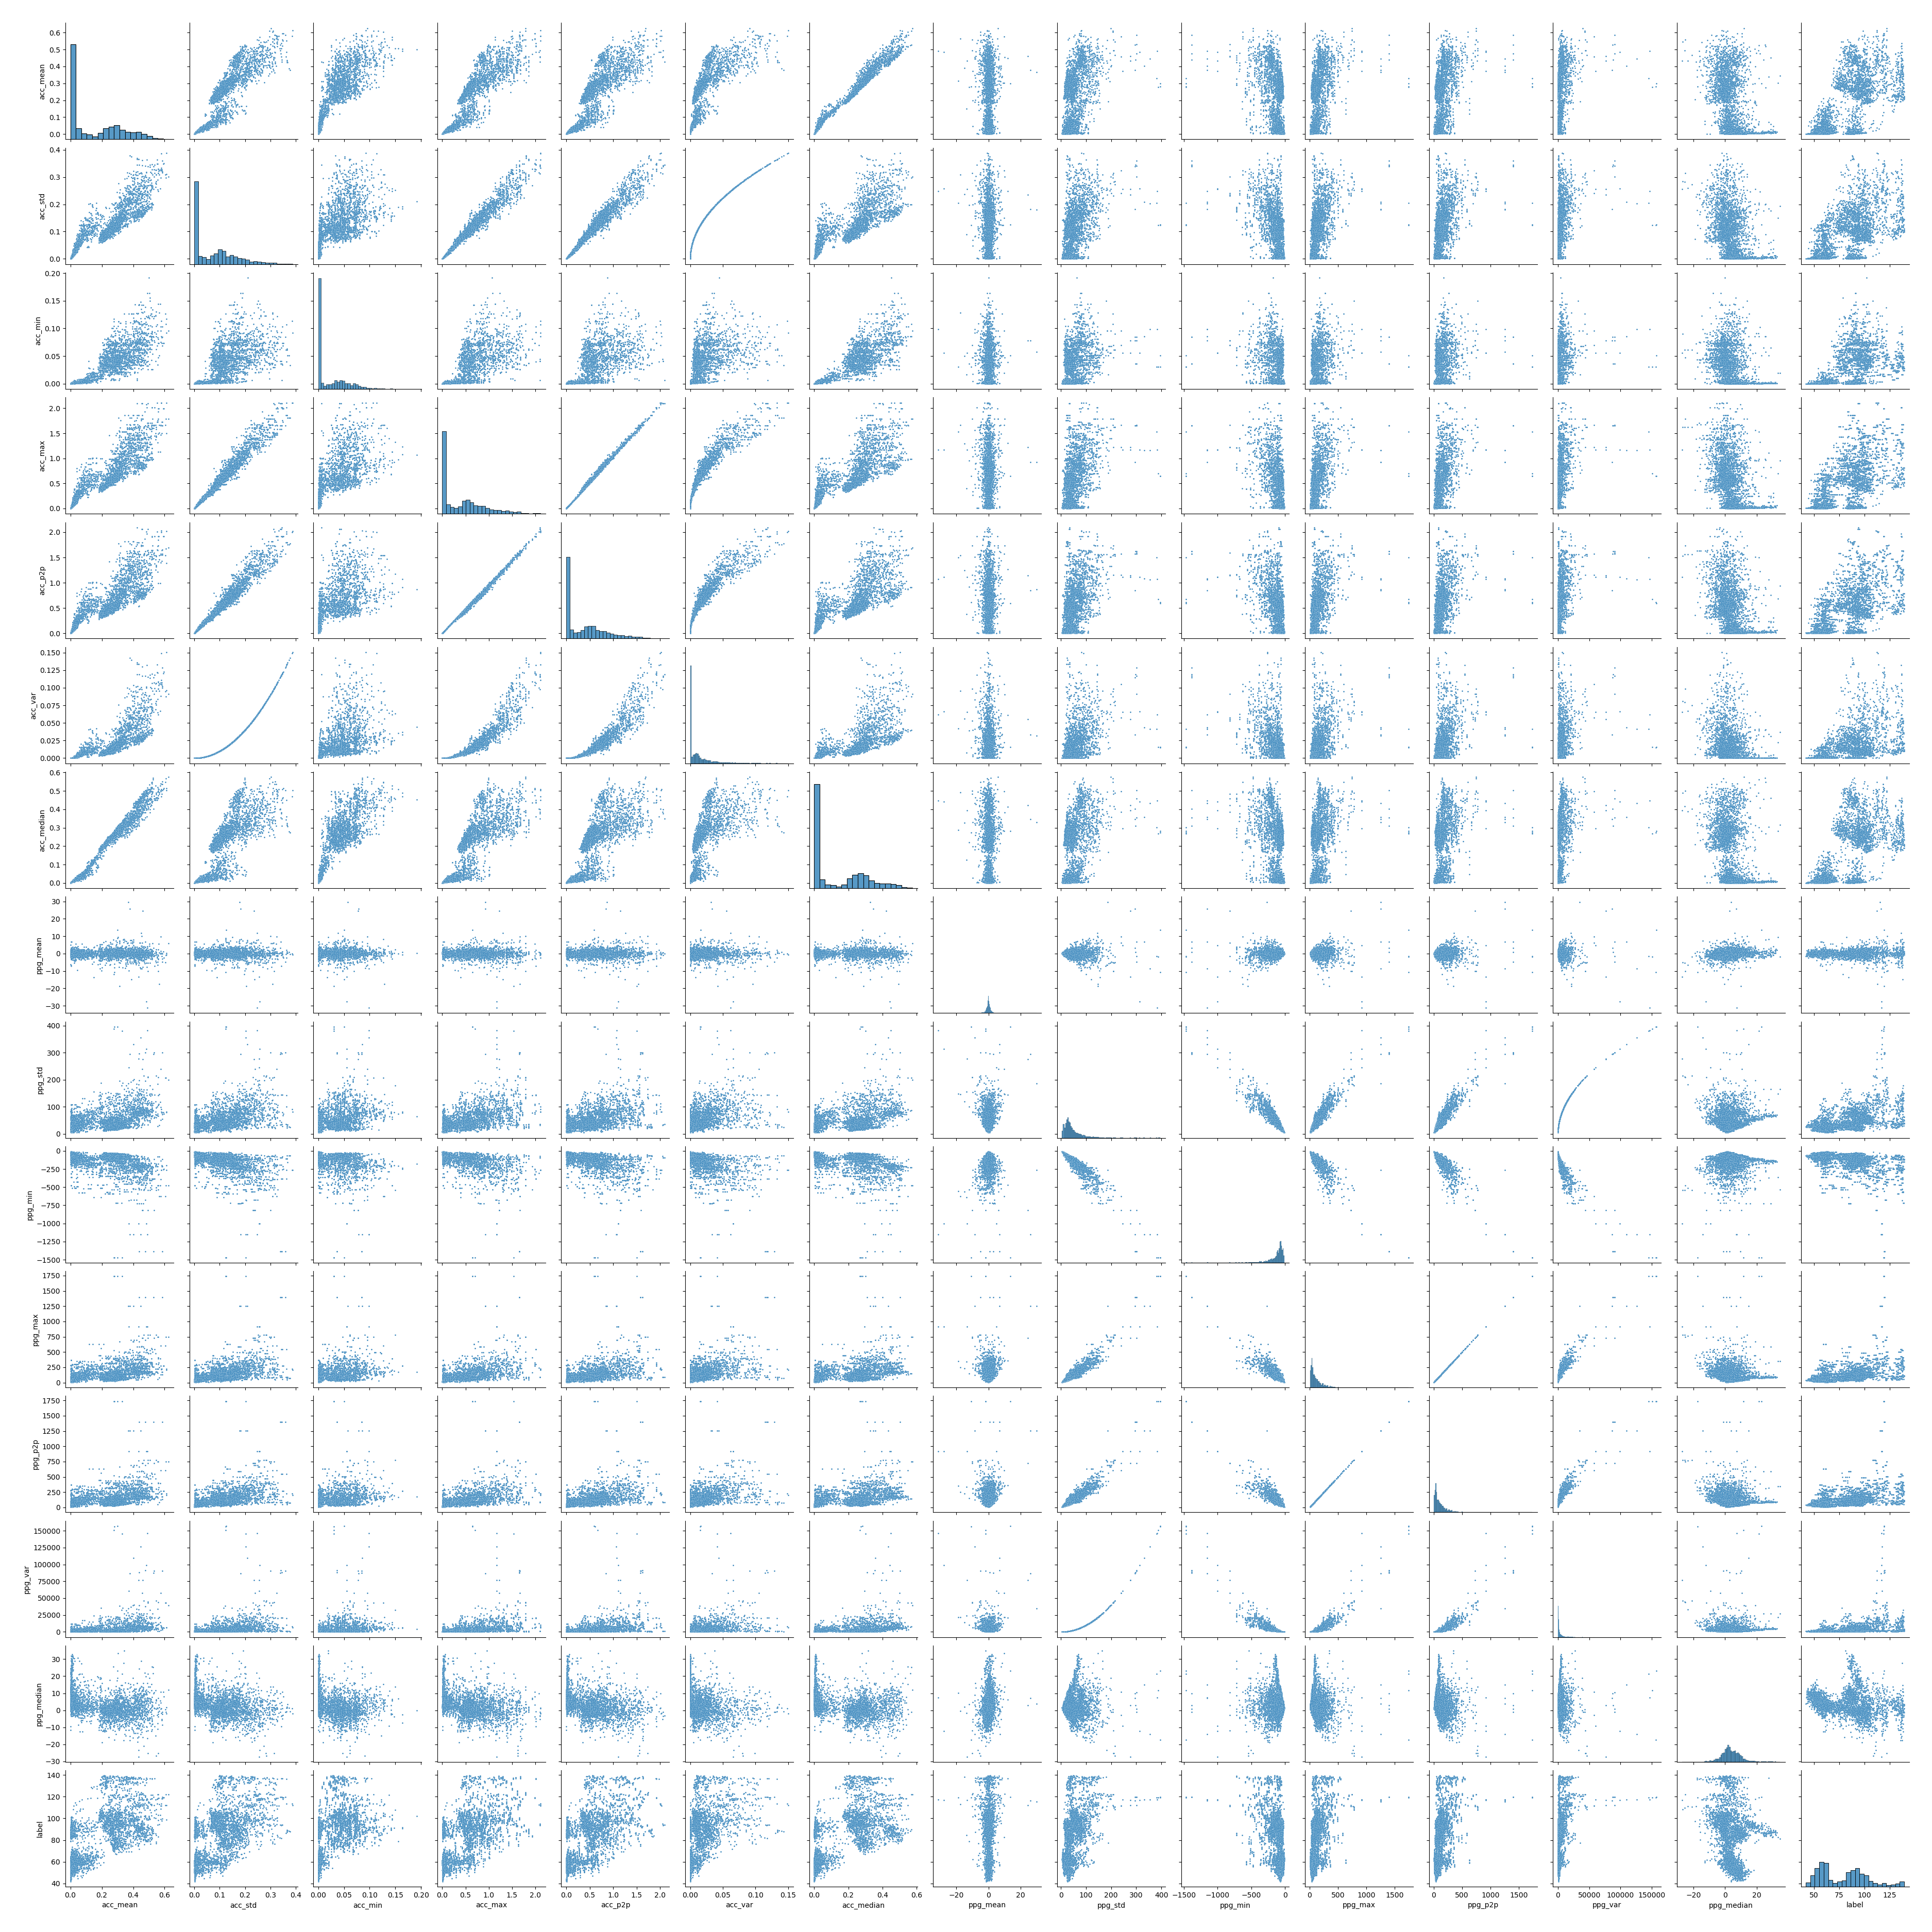

In [6]:
acc_norm = np.zeros([ppg_acc_windows.shape[0], ppg_acc_windows.shape[2]])
for instance in range(ppg_acc_windows.shape[0]):
    ppg_acc = ppg_acc_windows[instance, 1:, :]
    acc_norm[instance, :] = np.sqrt(np.sum(np.power(ppg_acc, 2), axis=0)) 


features = pd.DataFrame({
    'acc_mean': np.mean(acc_norm, axis=1),
    'acc_std': np.std(acc_norm, axis=1),
    'acc_min': np.min(acc_norm, axis=1),
    'acc_max': np.max(acc_norm, axis=1), 
    'acc_p2p': np.max(acc_norm, axis=1) - np.min(acc_norm, axis=1), 
    'acc_var': np.power(np.std(acc_norm, axis=1), 2),
    'acc_median': np.median(acc_norm, axis=1),
    'ppg_mean': np.mean(ppg_windows, axis=1),
    'ppg_std': np.std(ppg_windows, axis=1),
    'ppg_min': np.min(ppg_windows, axis=1),
    'ppg_max': np.max(ppg_windows, axis=1), 
    'ppg_p2p': np.max(ppg_windows, axis=1) - np.min(acc_norm, axis=1), 
    'ppg_var': np.power(np.std(ppg_windows, axis=1), 2),
    'ppg_median': np.median(ppg_windows, axis=1),
})


def plot_features(f, y):
    data = f.copy()
    data['label'] = y.ravel()
    sns.pairplot(data, plot_kws={'s': 4})


plot_features(features.iloc[i_train], targets[i_train])

It is also possible to select the most relevant features using various methods. Here, we define implement three fature selection techniques: lasso, univariate, hybrid. 

In [7]:
class FeatureSelector:

    def __init__(self, method, numbers):
        self.method = method.lower()
        self.numbers = numbers

    def apply(self, features, targets):
        features_names = [column for column in features.columns 
                          if column not in ['reference']]
        features_selection = features.copy()
        features_selection.insert(0, 'reference', targets)
        features_selection = features_selection.dropna(axis=0, how='any', inplace=False)
        ranks = self.rank_features(features_selection[features_names],
                                   features_selection['reference'],
                                   self.method)
        del features_selection
        return self.select_features(ranks, self.numbers)

    @staticmethod
    def select_features(ranks, feature_num):
        ranks.sort_values(by='ranks', axis=0, ascending=False, inplace=True,
                          kind='quicksort', ignore_index=True)
        return ranks['feature_names'].iloc[: feature_num].tolist()

    @staticmethod
    def rank_features(features, reference, method):
        def univariate_selection(data, ref):
            selector = SelectKBest(f_regression, k="all")
            scores = selector.fit(data, ref).scores_
            return scores / np.nansum(scores)

        def lasso_selection(data, ref):
            alphas = np.arange(0.01, 0.3, 0.01)
            coefficients = np.empty([len(alphas), data.shape[1]])
            for row, alpha in enumerate(alphas):
                selector = SelectFromModel(Lasso(alpha=alpha), prefit=False)
                coefficients[row, :] = selector.fit(data, ref).estimator_.coef_
            coefficients = np.abs(coefficients)
            real_ranks = np.nansum(coefficients, axis=0)
            return real_ranks / np.nansum(real_ranks)

        if method == 'lasso':
            ranks = lasso_selection(features, reference)
        elif method == 'univariate':
            ranks = univariate_selection(features, reference)
        elif method == 'hybrid':
            rank_lasso = lasso_selection(features, reference)
            rank_univariate = univariate_selection(features, reference)
            rank_combined = rank_lasso + rank_univariate
            ranks = rank_combined / np.nansum(rank_combined)
        else:
            raise TypeError("Feature selection method is not supported")
        return pd.DataFrame({
            'feature_names': features.columns,
            'ranks': ranks,
        })

feature_selection_method = 'univariate'
feature_selection_numbers = 4
features_list = FeatureSelector(feature_selection_method, feature_selection_numbers).apply(features.iloc[i_val], targets[i_val])
print(f"Selected features:{features_list}")

Selected features:['acc_mean', 'acc_median', 'acc_std', 'acc_min']


Now we define the regression models: linear regression, support vector regression.

In [8]:
class ModelBuilder:

    def __init__(self, config):
        self.config = config['model']

    def apply(self):
        return eval(f"self._build_{self.config['name']}()")

    def _build_lregression(self):
        return make_pipeline(
            StandardScaler(),
            LinearRegression())

    def _build_svr(self, kernel='rbf', gamma='scale', regularization=1):
        if 'kernel' in self.config.keys():
            kernel = self.config['kernel']
        if 'gamma' in self.config.keys():
            gamma = self.config['gamma']
        if 'regularization' in self.config.keys():
            regularization = self.config['regularization']
        return make_pipeline(
            StandardScaler(),
            SVR(kernel=kernel, gamma=gamma, C=regularization))

Now, we define a class for the training of the models.

In [9]:
class ModelTrainer:

    def __init__(self, config):
        self.config = config['feature']

    def apply(self, model, features, reference, i_train):
        features_list = self._get_features_list(list(features.columns))
        features_train = features.copy()
        features_train.insert(0, 'reference', reference)
        features_train = features_train.iloc[i_train].copy()
        
        features_train = features_train.dropna(axis=0, how='any', inplace=False,
                                               subset=features_list + ['reference'])
        return model.fit(
            features_train[features_list].values, features_train['reference'].values)

    def _get_features_list(self, current_features):
        if 'all' in self.config['list']:
            features_list = [feature for feature in current_features
                             if feature not in self.config['exclusion'] + ['reference']]
        else:
            features_list = [feature for feature in
                             self.config['list']
                             if feature in current_features and feature not
                             in self.config['exclusion'] + ['reference']]
        return features_list

We also define a class to apply the trained models on the test data.

In [10]:
class ModelTester:

    def __init__(self, config):
        self.config = config['feature']

    def apply(self, model, features):
        features_list = self._get_features_list(list(features.columns))
        inx = np.logical_not(
            np.sum(np.isnan(features[features_list]), 1).astype(bool))
        detections = np.zeros_like(inx, dtype=float)
        detections[:] = np.nan
        detections[inx] = model.predict(features[features_list].values[inx])
        return pd.DataFrame({
            'prediction': detections,
        })

    def _get_features_list(self, current_features):
        if 'all' in self.config['list']:
            features_list = [feature for feature in current_features
                             if feature not in self.config['exclusion'] + ['reference']]
        else:
            features_list = [feature for feature in
                             self.config['list']
                             if feature in current_features and feature not
                             in self.config['exclusion'] + ['reference']]
        return features_list

Inorder to evaluate the results of the models, we define an Evaluator class as follows:

In [11]:
class Evaluator:

    def __init__(self):
        pass
    
    def apply(self, result, reference, i_train, i_test):
        metrics = []
        for subset, indices in (('train', i_train), ('test', i_test)):
            metrics.append({
                'subset': subset,
                **self.compute_performance_parameters(result[indices], reference[indices]),
            })
        return pd.DataFrame(metrics)

    @staticmethod
    def compute_performance_parameters(result, reference):
        error = np.zeros_like(reference)
        error[:] = np.nan
        inx = reference != 0
        error[inx] = 100 * ((reference[inx] - result[inx]) / reference[inx])
        error = error[error != np.nan]
        return {
            'mean': np.mean(error),
            'std': np.std(error),
            'rmse': np.sqrt(np.mean(np.power(error, 2))),
        }

The final step before training and evaluating the models is to define the configurations of the different models.

We will train the models with the following configurations:

* Linear without features selection
  * Using all the features

* Linear regression with features selection
  * Using the selected features

* SVR with features selection
  * Using the selected features
  * kernel: rbf
  * gamma:scale
  * regularization: 1

In [12]:
exclude_features = []
configs = {
    'linear_regression_all_features': {
        'feature': {
            'list': 'all',
            'exclusion': exclude_features,
            'selection_method': [],
            'selection_numbers': np.nan,
        },
        'model': {
            'name': 'lregression',
        },
    },
    'linear_regression_selected_features': {
        'feature': {
            'list': features_list,
            'exclusion': exclude_features,
            'selection_method': feature_selection_method,
            'selection_numbers': feature_selection_numbers,
        },
        'model': {
            'name': 'lregression',
        },
    },
    'svr_all_features': {
        'feature': {
            'list': 'all',
            'exclusion': exclude_features,
            'selection_method': [],
            'selection_numbers': np.nan,
        },
        'model': {
            'name': 'svr',
            'kernel': 'rbf',
            'gamma': 'scale',
            'regularization': 1, 
        },
    },
    'svr_selected_features': {
        'feature': {
            'list': features_list,
            'exclusion': exclude_features,
            'selection_method': feature_selection_method,
            'selection_numbers': feature_selection_numbers,
        },
        'model': {
            'name': 'svr',
            'kernel': 'rbf',
            'gamma': 'scale',
            'regularization': 1, 
        },
    },
}

Now, we are ready to train the models.

In [13]:
models = {}
for name, config in configs.items():
    print(f' * Training {name!r} model')
    model = ModelBuilder(config).apply()
    models[name] = ModelTrainer(config).apply(model, features, targets, i_train)

 * Training 'linear_regression_all_features' model
 * Training 'linear_regression_selected_features' model
 * Training 'svr_all_features' model
 * Training 'svr_selected_features' model


Here, we evaluate the trained models on the features.

In [14]:
output = {}
for name, config in configs.items():
    print(f' * Applying {name!r} model')
    output[name] = ModelTester(config).apply(models[name], features)

 * Applying 'linear_regression_all_features' model
 * Applying 'linear_regression_selected_features' model
 * Applying 'svr_all_features' model
 * Applying 'svr_selected_features' model


Now that all models are trained we can evaluate them on the subsets for training, validation, and testing.

In [15]:
metrics = []
for name, config in configs.items():
    print(f'Evaluating {name!r} model')
    performance = Evaluator().apply(output[name]['prediction'].values, targets[:, 0], i_train, i_test)
    performance.insert(0, 'model', name)
    metrics.append(performance)
print("\n*** Performance report ***\n")
metrics = pd.concat(metrics, axis=0, ignore_index=True)
metrics = metrics.set_index(['model', 'subset'])
index = metrics.index.get_level_values(0).unique()
columns = pd.MultiIndex.from_product([metrics.columns, metrics.index.get_level_values(1).unique()])
metrics = metrics.unstack().reindex(index=index, columns=columns)
IPython.display.display(metrics)

Evaluating 'linear_regression_all_features' model
Evaluating 'linear_regression_selected_features' model
Evaluating 'svr_all_features' model
Evaluating 'svr_selected_features' model

*** Performance report ***



mean                   std  \
subset                                  train       test      train   
model                                                                 
linear_regression_all_features      -3.924053 -12.435107  19.565851   
linear_regression_selected_features -4.549709  -8.650772  20.517729   
svr_all_features                     0.418621  -7.181589  16.625634   
svr_selected_features                1.217230  -2.908962  17.959907   

                                                     rmse             
subset                                    test      train       test  
model                                                                 
linear_regression_all_features       17.199001  19.955468  21.223514  
linear_regression_selected_features  16.334608  21.016114  18.483919  
svr_all_features                     15.572246  16.630904  17.148471  
svr_selected_features                10.697804  18.001109  11.086256

We can also plot the different metrics.

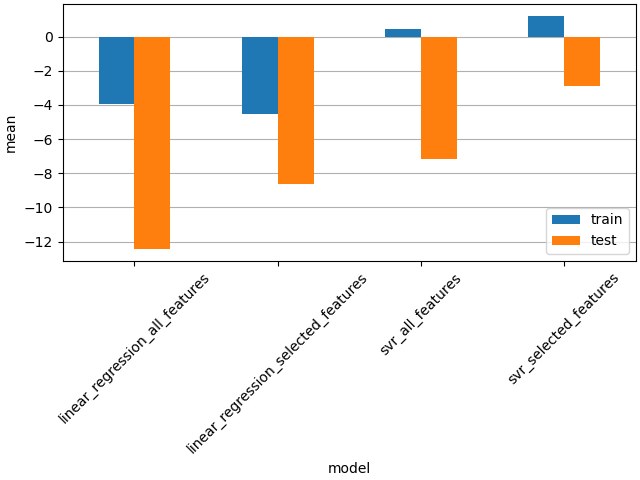

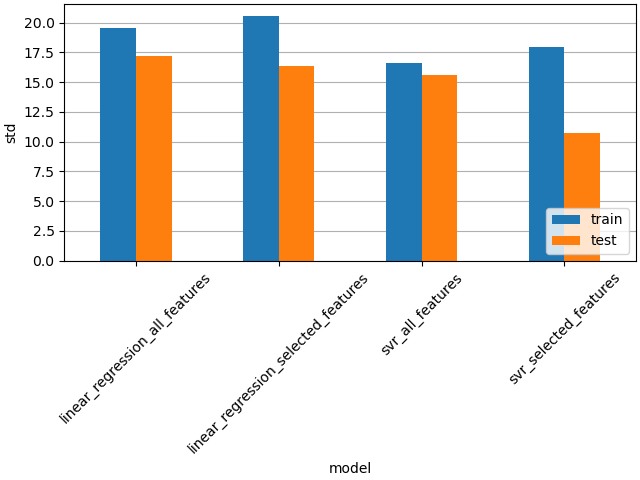

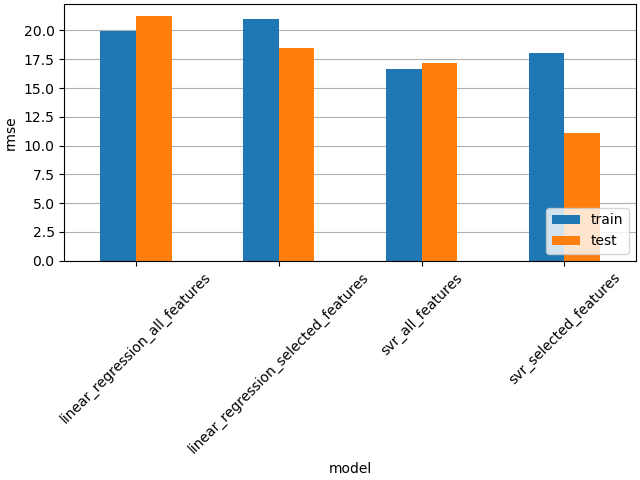

In [16]:
def plot_metrics(data):
    for metric in data.columns.get_level_values(0).unique():
        if metric == 'count':
            continue
        df = data[metric]
        plt.figure(constrained_layout=True)
        plt.gca().set_axisbelow(True)
        df.plot(kind='bar', ylabel=metric, ax=plt.gca())
        plt.grid(axis='y')
        plt.legend(loc='lower right')
        plt.gca().xaxis.set_tick_params(rotation=45)

    
plot_metrics(metrics)

# 1.3 Problems 


**P1.** If you want to select a set of features manually, which features would you choose and why?  

To choose the features in a manually way, we proceed by elimination. By looking at the figure 3, we first look at the plots that have the most correlation. Their graphs are linear or quadratic. By doing this, we see that acc_max and acc_p2p are correlated. There are also acc_var and acc_std, ppg_var and ppg_std, ppg_p2p and ppg_max. Therefore we selected only one of the two variables for each case: ppg_var, ppg_p2p, acc_var and acc_p2p. Another reason for the selection of the variation instead of the standard deviation is that the standard deviation comes from the variation.
We select label as his plots are very unalike from each other. Then we deselect other variables by the resemblance of their plots. The reason behind is that the effect of this variable is the same for other variables which is a minus for fitting and testing. Another condition is that their plots look a lot with the plots of another variable. This is the case for acc_median, ppg_min and ppg_median. ppg_mean has a curve that is mostly equal to 0 therefore, he would have no or little impact on other variables. Finally, we choose acc_mean and acc_min.

**P2.** Do the automatically selected features match your manually selected features? Explain the reasons for any similarities and/or differences.

They do not but this is normal since the feature selection is a process that depends on the chosen method for feat. selection.

in the real life this process is usually done with different methods that are compared to each other and furthermore compared to the real life problem where the decision is made knowing the feature effect on what we want to study

**P3.** Do you think that the feature selection was useful in this exercise? Why? 

Feature selection in this cas was indeed useful. Notably we can see straight forward that some features are correlated between each other and thus they "explain" each other. Removing theses features will allow a better performance regarding the model computational cost.

**P4.** How do you interpret mean, std, and rmse errors of the models? 

The mean of a model is the bias, which represents the average accuracy of the model. Its sign indicates whether the model has a tendency to over or underestimate the real value (on average).

The standard deviation of a model is the accuracy of the model for each prediction it makes (precision).

Finally, the mean squared error is joining the accuracy and the precision. It is used as a general error indicator.

**P5.** Considering all conditions, which model will you finally choose to estimate heart rate? Why?

Multiple conditions exist to choose the model. In this case we will look at the mean, the std and the rmse to choose the model. By looking on the graph, svr with all the features look like the best model as two conditions (rmse and std) over three applied to the test and train are closest to each other compared to the other models.
